# Calibrating qubits using Qiskit Pulse

Qiskit is an open-source framework for programming quantum computers (Ref. [1](#refs)). Using Qiskit, quantum circuits can be built, simulated and executed on quantum devices.

OpenPulse provides a language for specifying pulse level control (i.e. control of the continuous time dynamics of input signals) of a general quantum device independent of the specific hardware implementation (Ref. [2](#refs)). 

In this tutorial, we show how to implement typical single-qubit calibration and characterization experiments using Qiskit and OpenPulse. These are typically the first round of experiments that would be done in the lab immediately after a device has been fabricated and installed into a system. The presentation is pedagogical, and allows students to explore two-level-system dynamics experimentally. All units are returned as standard SI (ie Hz, sec, etc).

Each experiment gives us more information about the system, which is typically used in subsequent experiments. For this reason, this notebook has to be mostly executed in order.

## Contents

0. [Getting started](#importing)
1. [Finding the qubit frequency using a frequency sweep](#frequencysweep)
2. [Calibrating and using a $\pi$ pulse](#calib)    
  2.1 [Calibrating $\pi$ pulses using a Rabi experiment](#rabi)    
  2.2 [Determining 0 vs 1](#zerovone)    
  2.3 [Measuring $T_1$ using inversion recovery](#T1)    
3. [Determining qubit coherence](#det_co)    
  3.1 [Measuring the qubit frequency precisely using a Ramsey experiment](#ramsey)    
  3.2 [Measuring $T_2$ using Hahn echoes](#hahn)    
4. [References](#refs)

## 0. Getting started <a id="importing"></a>

We'll first get our basic dependencies set up and ready to go. Since we want to use real, noisy devices for our calibration experiments in this notebook, we need to load our IBMQ account and set the appropriate backend.

In [1]:
from qiskit.tools.jupyter import *
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

#ONLY ARMONK SUPPORTS OPEN_PULSE
backend = provider.get_backend('ibmq_armonk')

In [2]:
#check what has OpenPulse support.
#[backend for backend in list(map(lambda x: x.name(),provider.backends()))[1:] if provider.get_backend(backend).configuration().open_pulse]

For instance, we can find the **sampling time for the backend pulses** within the backend configuration. This will be a very useful value to us as we build and execute our calibration routines.

In [3]:
#NB backend_config is a PulseBackendConfiguration instance,
#not a normal BackendConfiguration
backend_config = backend.configuration()

dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


The backend defaults provide a starting point for how to use the backend. It contains estimates for qubit frequencies and default programs to enact basic quantum operators. We can access them with the following:

In [4]:
backend_defaults = backend.defaults()

# Part 1
## 1. Finding the qubit frequency using a frequency sweep <a id="frequencysweep"></a>

We begin by searching for the qubit frequency. The **qubit frequency is the difference in energy between the ground and excited states**, which we label the $\vert0\rangle$ and $\vert1\rangle$ states, respectively. This frequency will be crucial for creating pulses which enact particular quantum operators on the qubit -- the final goal of our calibration!

In a typical lab setting, the qubit frequency can be found by **sweeping a range of frequencies** and looking for signs of absorption using a tool known as a Network Analyzer. This measurement gives a rough estimate of the qubit frequency. Later on, we will see how to do a more precise measurement using a Ramsey pulse sequence.

First, we define the frequency range that will be swept in search of the qubit. Since this can be arbitrarily broad, we restrict ourselves to a window of 40 MHz around the estimated qubit frequency in `backend_defaults`. We step the frequency in units of 1 MHz.

In [5]:


# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974445794773773 GHz.
The sweep will go from 4.954445794773773 GHz to 4.994445794773773 GHz in steps of 1.0 MHz.


Next, we define the pulses we will use for our experiment. We will start with the drive pulse, which is a Gaussian pulse.

**Remember the value `dt` from earlier? All durations in pulse are given in terms of `dt`.** In the next cell, we define the length of the drive pulse in terms of `dt`.

**NB**
`pulse_lib.gaussian()` returns $f(x) = A\textrm{exp}(-\frac{(x-d/2)^2}{2\sigma^2})$ for $0 \leq x \leq d $

In [6]:
# samples need to be multiples of 16 (Just a fact)
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [7]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian (drive = Gaussian)
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3                                                         # Amplitude of pulse?
# Drive pulse samples

drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In order to properly measure our qubits, we need to check the measurement map.
**meas_map() is a list of lists indicating all measurements which are multiplexed together.**
eg [[0], [1,2]] Q0 is measured independently, but Q1 and Q2 are multiplexed together

**This is a hardware constraint.** When acquisition is done for one qubit, it is also done on other qubits. We have to respect this constraint when building our program in Pulse. Let's check which group of qubits our qubit is in:

In [8]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

Now we can define our measurement pulse. **Rather than hard coding the pulse, we can obtain a calibrated measurement pulse from the backend default instruction schedule map**. Because it is frequently calibrated, it is more accurate than defining a measurement pulse ourselves. This measurement pulse also includes acquisition so we do not need to add that in manually.

In [9]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

Lastly, we specify the channels on which we will apply our pulses. Drive, measure, and acquire channels are indexed by qubit index.

In [10]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Now that the pulse parameters have been defined, and we have created the pulse shapes for our experiments, we can proceed to creating the pulse schedules.



At each frequency, we will send a drive pulse of that frequency to the qubit and measure immediately after the pulse. The pulse envelopes are independent of frequency, so we will build a reusable `schedule`, and we will specify the drive pulse frequency with a frequency configuration array.

In [11]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(pulse=drive_pulse, channel=drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz

#frequency configuration array
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

As a sanity check, it's always a good idea to look at the pulse schedule. This is done using `schedule.draw()` as shown below. 

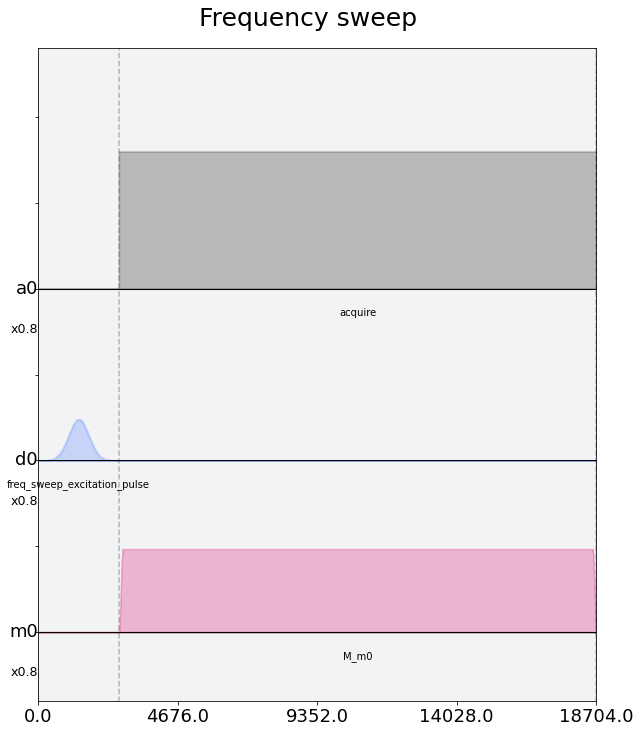

In [12]:
schedule.draw(label=True, scaling=0.8)

We assemble the `schedules` and `schedule_frequencies` above into a program object, called a Qobj, that can be sent to the quantum device. We request that each schedule (each point in our frequency sweep) is repeated `num_shots_per_frequency` times in order to get a good estimate of the qubit response.

We also specify measurement settings.
**`meas_level=0` returns raw data (an array of complex values per shot);
`meas_level=1` returns kerneled data (one complex value per shot - result from lab) 
`meas_level=2` returns classified data (a 0 or 1 bit per shot - result after discrimnation).**

We choose `meas_level=1` to replicate what we would be working with if we were in the lab, and hadn't yet calibrated the discriminator to classify 0s and 1s. We ask for the `'avg'` of the results, rather than each shot individually.

In [13]:
from qiskit import assemble

num_shots_per_frequency = 1024

#assemble turns a pulse schedule into a QObj 
#(hardware-agnostic) compiler
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

You may see yet another unit change warning, we can safely ignore this. Finally, we can run the assembled program on the backend using:

In [14]:
job = backend.run(frequency_sweep_program)

It is always a good idea to print the `job_id` for later retrieval, and to monitor the job status by using `job_monitor()`

In [15]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


Once the job is run, the results can be retrieved using:

In [16]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

We will extract the results and plot them using `matplotlib`:

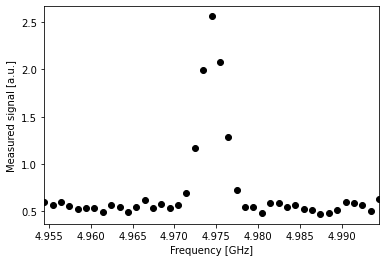

In [17]:

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

As you can see above, the peak near the center corresponds to the location of the qubit frequency. The signal shows **power-broadening**, which is a signature that we are able to drive the qubit off-resonance as we get close to the center frequency. To get the value of the peak frequency, we will **fit the values** to a resonance response curve, which is typically a **Lorentzian shape.**

In [18]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=100000)
    #remember a * in a function call unpacks fitparams tuple into
    #normal positional function arguments
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

Spectral lines (absorption or inverse intensity vs wavelength) often follow a **Voigt shape** (convolution between Cauchy-Lorentz and Gaussian), rather than the idealised Dirac delta. Primary reasons are:
1) **Lifetime broadening**; a minimum line width is implied by the Heisenberg Uncertainty Principle (HUP).
2) **Doppler broadening**; observed velocity of atoms follows a temp-dependent Maxwell distribution. This implies a Gaussian shape.
3) **Pressure broadening**; collisions reduce effective lifetime of excited states, so HUP => uncertainty in absorption energy increases. Implies a Lorentzian shape.
4) Proximity broadening effects eg Hydrogen bonding

**Idealised Lorentzian** shape is $$\textrm{Absorption} = \frac{1}{1 + \left(\frac{\nu - \nu_\textrm{max}}{\omega/2}\right)^2},$$ where $\omega$ is the full width at half maximum, $\nu$ is frequency and $\nu_\textrm{max}$ is frequency at the peak.

In [19]:
#Why on earth are A and B both required? Cell not very well written.
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, 4.975, 1, 3], # initial parameters for curve_fit
                                
                                )


C = shifting param
B = w
A := b*np.pi by model??? Why not???
q_freq = freq_at_max_signal

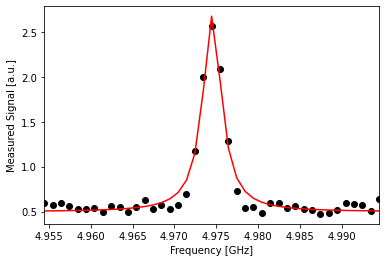

In [20]:
#qcircuit mmts as black scatter lot
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')

#values fitted on Lorentzian distro as red scatter plot
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [21]:

A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97445 GHz to 4.97451 GHz.


# Part 2. Calibrating and using a $\pi$ pulse <a id="calib"></a>
## A. Calibrating $\pi$ pulses using a Rabi experiment <a id="rabi"></a>

Once we know the frequency of our qubit, the next step is to **determine the strength of a $\pi$ pulse**. Strictly speaking of the qubit as a two-level system, a $\pi$ pulse is one that takes the qubit from $\vert0\rangle$ to $\vert1\rangle$, and vice versa. This is **also called the $X$** or $X180$ gate, or bit-flip operator. We already know the microwave frequency needed to drive this transition from the previous frequency sweep experiment, and we **now seek the amplitude needed** to achieve a $\pi$ rotation from $\vert0\rangle$ to $\vert1\rangle$. (ie the total number of photons in the pulse)


<img src="https://github.com/aasfaw/qiskit-intros/blob/master/zero_to_one_X180.png?raw=true">


We will change the drive amplitude in small increments and measuring the state of the qubit each time. We expect to see oscillations which are commonly named Rabi oscillations, as the qubit goes from $\vert0\rangle$ to $\vert1\rangle$ and back.

In [23]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [24]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

The schedule will look essentially the same as the frequency sweep experiment. The only difference is that we are running a set of experiments which vary the amplitude of the drive pulse (keeping frequency constant), rather than its modulation frequency.

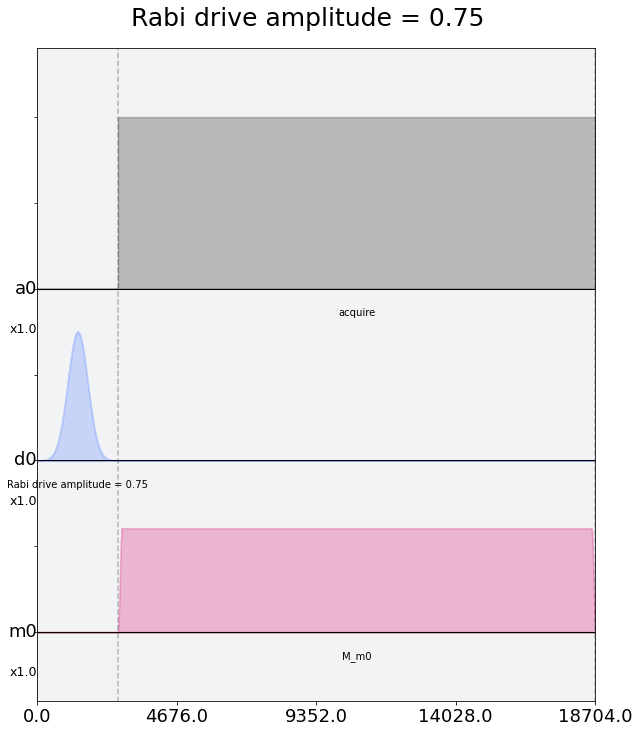

In [25]:
rabi_schedules[-1].draw(label=True, scaling=1.0)

In [26]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [27]:
# print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

Job Status: job has successfully run


In [28]:
rabi_results = job.result(timeout=120)

Now that we have our results, we will extract them and fit them to a sinusoidal curve. For the range of drive amplitudes we selected, we expect that we will rotate the qubit several times completely around the Bloch sphere, starting from $|0\rangle$. 
The amplitude of this sinusoid tells us the fraction of the shots at that Rabi drive amplitude which yielded the $|1\rangle$ state.  We want to find the drive amplitude needed for the signal to oscillate from a maximum (all $|1\rangle$ state) to a minimum (all $|0\rangle$ state) -- this gives the calibrated amplitude that enacts a $\pi$ pulse.

In [29]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

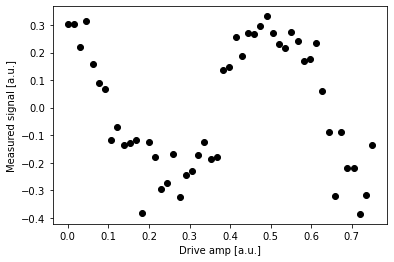

In [30]:
    rabi_values = []
    for i in range(num_rabi_points):
        # Get the results for `qubit` from the ith experiment
        rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

    rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

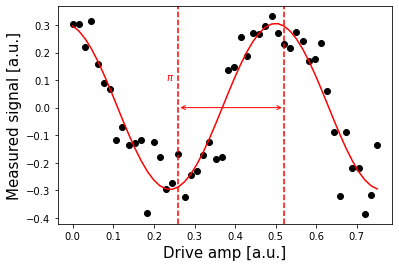

In [31]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values,
                                 #A = amplitude, phi=phase diff, B = translation
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [32]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.2601559810095089


### Our $\pi$ pulse!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

In [33]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

## B. Determining 0 vs 1 <a id="zerovone"></a>

Once our $\pi$ pulses have been calibrated, we can **now create the state $\vert1\rangle$ with good probability.** We can use this to find out what the states $\vert0\rangle$ and $\vert1\rangle$ look like in our measurements, by repeatedly preparing them and plotting the measured signal. **This is what we use to build a discriminator, which is simply a function which takes a measured and kerneled complex value (`meas_level=1`) and classifies it as a 0 or a 1 (`meas_level=2`).**

In [62]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(pi_pulse, drive_chan)  # We found this in Part 2A above
exc_schedule += measure << exc_schedule.duration

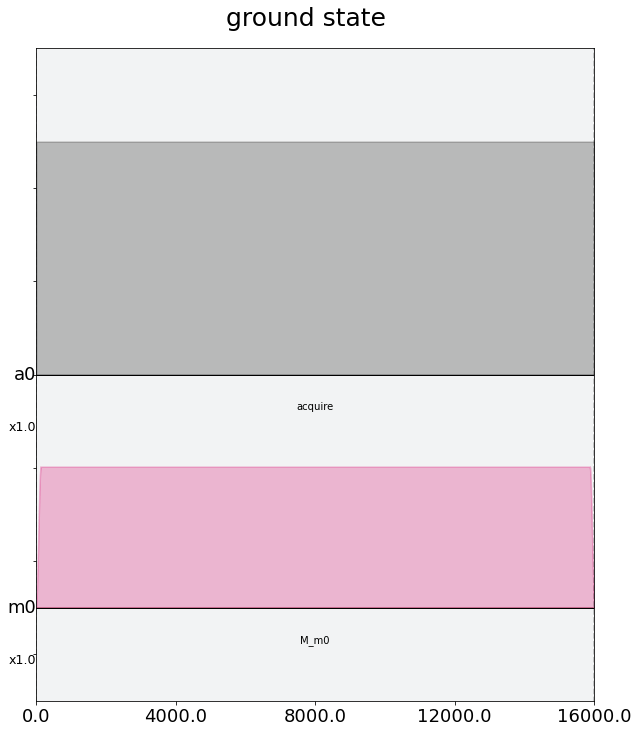

In [63]:
gnd_schedule.draw(label=True, scaling=1.0)

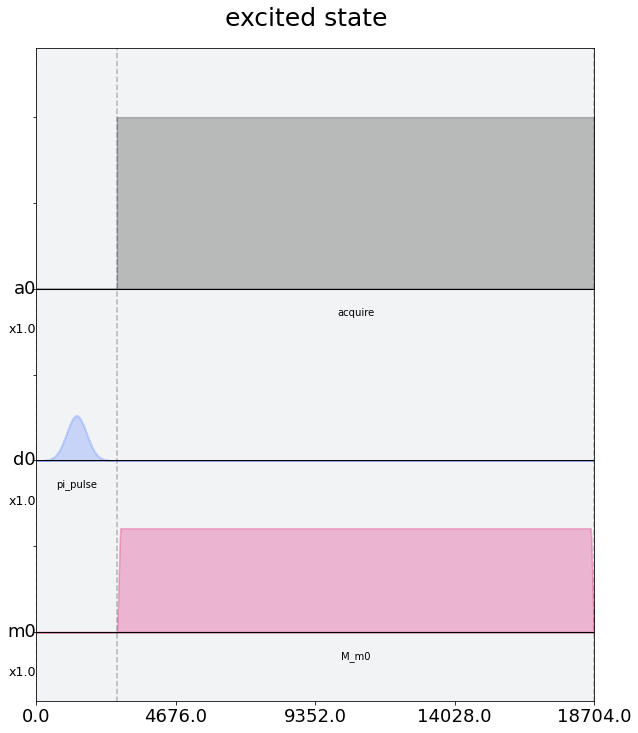

In [47]:
exc_schedule.draw(label=True, scaling=1.0)

We assemble the ground and excited state preparation schedules into one Qobj. Each of these will run `num_shots` times. We choose `meas_level=1` this time, because we do not want the results already classified for us as $|0\rangle$ or $|1\rangle$. Instead, **we want kerneled data: raw acquired data that has gone through a kernel function to yield a single complex value for each shot.**
We pass the same frequency for both schedules, although it is only used by the `exc_schedule`.

In [64]:
# Execution settings
num_shots = 1024

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

In [65]:
# print(job.job_id())
job = backend.run(gnd_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [66]:
gnd_exc_results = job.result(timeout=120)

Now that we have the results, we can visualize the two populations which we have prepared on a simple scatter plot, showing results from the **ground state program in blue** and results from the **excited state preparation program in red**. Note: If the populations irregularly shaped (not approximately circular), try re-running the notebook.

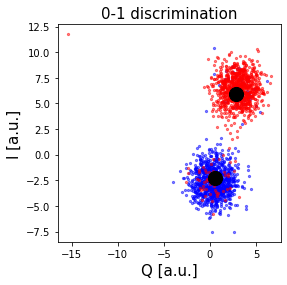

In [67]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

We can clearly see that the two populations of $|0\rangle$ and $|1\rangle$ form their own clusters. Kerneled measurement results (from `meas_level=1`) are classified (into `meas_level=2`) by applying a discriminator which optimally separates these two clusters. Optimal separation is simply a line in the IQ plane, equidistant from the average results we plotted above in the large dot, and normal to the line connecting the two dots.

We can set up a quick classifier function by returning 0 if a given point is closer to the mean of the ground state results, and returning 1 if the point is closer to the average excited state results. (Kind of like an SVM)?

In [68]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

## C. Measuring $T_1$ using inversion recovery <a id="T1"></a>
The **$T_1$ time of a qubit is the time it takes for a qubit to decay from the excited state to the ground state**. It is important because it limits the duration of meaningful programs we can run on the quantum computer.

Measuring $T_1$ is similar to our previous experiments, and uses the $\pi$ pulse we've calibrated. We again apply a single drive pulse, our $\pi$ pulse, then apply a measure pulse. However, this time we do not apply the measurement immediately. **We insert a delay, and vary that delay between experiments. When we plot the measured signal against delay time, we will see a signal that decays exponentially as the qubit relaxes in energy. The decay time is the $T_1$, or relaxation time, of the qubit!**

In [69]:
# T1 experiment parameters
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt
# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [70]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    
    #NB |= is BITWISE OR, unsure why it is used here.
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)

We can check out our $T_1$ schedule, too. To really get a sense of this experiment, try looking at a couple of the schedules by running the next cell multiple times, with different values of `sched_idx`. You will see the measurement pulse start later as you increase `sched_idx`.

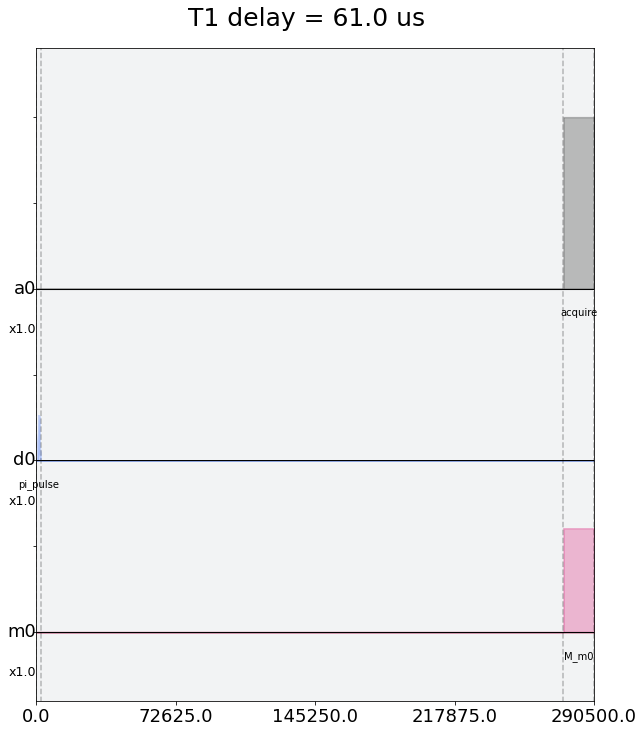

In [71]:
sched_idx = 10
t1_schedules[sched_idx].draw(label=True, scaling=1.0)

In [72]:
# Execution settings
num_shots = 1024

t1_experiment = assemble(t1_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_frequency}] * len(t1_schedules))

In [73]:
job = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [74]:
t1_results = job.result(timeout=120)

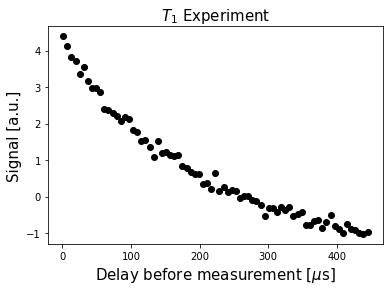

In [75]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

**We can then fit the data to a decaying exponential, giving us T1!** Remember $\lambda = \frac{\ln2}{T_1}$ is the exponential decay rate.

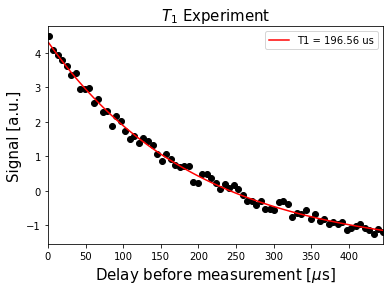

In [60]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

# Part 3. Determining qubit coherence <a id="det_co"></a>
## A. Measuring the qubit frequency precisely using a Ramsey experiment <a id="ramsey"></a>

Now, we **determine the qubit frequency to better precision**. This is done using a Ramsey pulse sequence. In this pulse sequence, we first apply a $\pi/2$ pulse, wait some time $\Delta t$, and then apply another $\pi/2$ pulse. Since we are measuring the signal from the qubit at the same frequency as the pulses, we should observe oscillations at the difference in frequency between the applied pulses and the qubit.

**We use the fact that the drive amplitude for $\pi/2$ is half the drive amplitude for a $\pi$ rotation.** The state below is $$\frac{\vert0\rangle - i\vert1\rangle}{\sqrt2}$$

<img src="https://github.com/aasfaw/qiskit-intros/blob/master/dephasing.png?raw=true">

In [34]:
# Ramsey experiment parameters
time_max_us = 1.8
time_step_us = 0.025
times_us = np.arange(0.1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2
# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
x90_pulse = pulse_lib.gaussian(duration=drive_samples,
                               amp=drive_amp, 
                               sigma=drive_sigma,
                               name='x90_pulse')

In [35]:
# create schedules for Ramsey experiment 
ramsey_schedules = []


for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"Ramsey delay = {delay * dt / us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)

    ramsey_schedules.append(this_schedule)

Just like for $T_1$ schedules, it will be illuminating to execute the next cell multiple times to inspect a few of the schedules we've made. As you look at increasing indices of `ramsey_schedules`, the delay between the two $\pi/2$ pulses will increase.

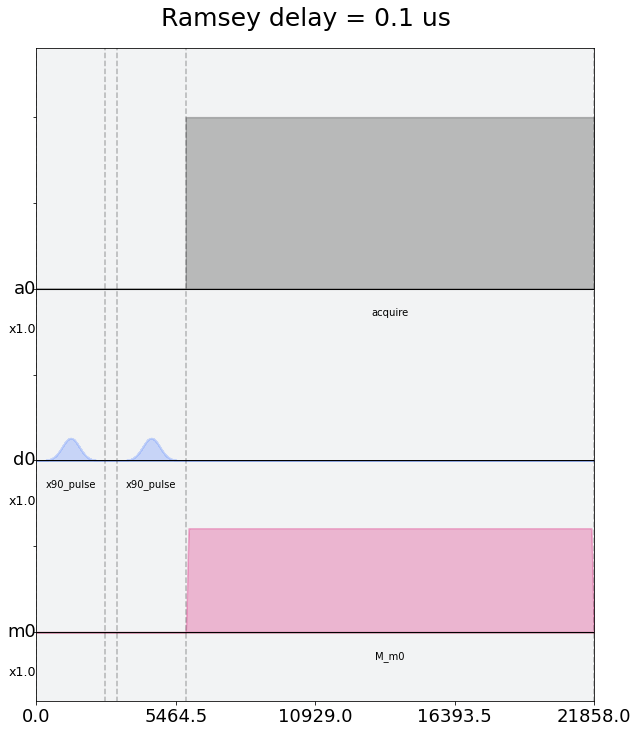

In [36]:
ramsey_schedules[0].draw(label=True, scaling=1.0)

Here, we will apply a commonly used **experimental trick.** We will **drive the pulses off-resonance** by a known amount, which we will call `detuning_MHz`. The measured Ramsey signal should show oscillations with frequency near `detuning_MHz`, with a small offset. **This small offset is exactly how far away `rough_qubit_frequency` was from the qubit frequency.**

In [38]:
# Execution settings
num_shots = 1024

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz
ramsey_program = assemble(ramsey_schedules,
                             backend=backend,
                             meas_level=1, #still using the kernelised results
                             meas_return='avg',
                             shots=num_shots,
                             
                             #Experiment Local Oscillator configuration object, user-specified frequencies.
                             schedule_los=[{drive_chan: ramsey_frequency}]*len(ramsey_schedules)
                            )

In [39]:
job = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [40]:
ramsey_results = job.result(timeout=120)

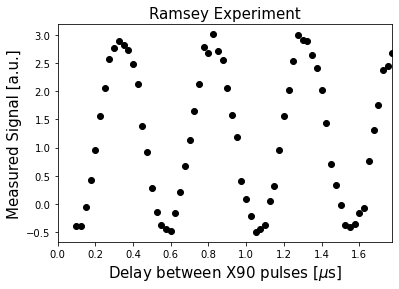

In [41]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results.get_memory(i)[qubit]*scale_factor)
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

We will fit the data to a sinusoid, and extract the information we are interested in -- namely, **$\Delta f$, the frequency of the sinusoid.**

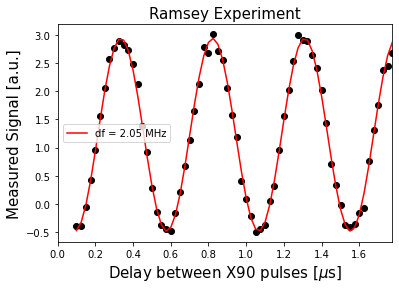

In [42]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

Now that we know `del_f_MHz`, we can update our estimate of the qubit frequency.

In [43]:

precise_qubit_freq = rough_qubit_frequency + (del_f_MHz - detuning_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 4.974563 GHz. It used to be 4.974511 GHz


## B. Measuring $T_2$ using Hahn echoes <a id="hahn"></a>

Next, we can measure the **coherence time**, $T_2$, of our qubit. The pulse sequence used to do this experiment is known as a **Hahn echo**, a term that comes from the NMR community. A Hahn echo experiment is very similar to the Ramsey experiment above, with an additional $\pi$ pulse between the two $\pi/2$ pulses. The $\pi$ pulse at time $\tau$ reverses the accumulation of phase, and results in an echo at time $2\tau$, where we apply the last $\pi/2$ pulse to do our measurement. 

The decay time for the Hahn echo experiment gives us the coherence time, $T_2$.

In [ ]:
# T2 experiment parameters
tau_max_us = 200
tau_step_us = 4
taus_us = np.arange(2, tau_max_us, tau_step_us)
# Convert to units of dt
delay_times_dt = taus_us * us / dt

# We will use the pi_pulse and x90_pulse from previous experiments

In [ ]:
t2_schedules = []
for tau in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T2 delay = {tau *dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= measure << int(this_schedule.duration)
    
    t2_schedules.append(this_schedule)

In [ ]:
t2_schedules[0].draw(label=True, scaling=1.0)

In [ ]:
# Execution settings
num_shots_per_point = 512

t2_experiment = assemble(t2_schedules,
                         backend=backend,
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots_per_point,
                         schedule_los=[{drive_chan: precise_qubit_freq}]
                                      * len(t2_schedules))

In [ ]:
job = backend.run(t2_experiment)
# print(job.job_id())
job_monitor(job)

In [ ]:
t2_results = job.result(timeout=120)

In [ ]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results.get_memory(i)[qubit]*scale_factor)

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

In [ ]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

## C. Dynamical decoupling <a id="DD"></a>

A single $\pi$ pulse is able to **eliminate quasi-static noise due to the reversal of phase accumulation**. This concept can be extended to noise that cannot be approximated as quasi-static by applying several $\pi$ pulses in succession. This technique, commonly known as dynamical decoupling, allows us to cancel different frequencies of noise and is used to extract longer coherence times from qubits.

In [ ]:
# DD experiment parameters
tau_us_min = 1
tau_us_max = 40
tau_step_us = 1.5
taus_us = np.arange(tau_us_min, tau_us_max, tau_step_us)
# Convert to units of dt
taus_dt = taus_us * us / dt
num_pi_pulses = 6 # apply two pi pulses
print(f"Total time ranges from {2.*num_pi_pulses*taus_us[0]} to {2.*num_pi_pulses*taus_us[-1]} us")

In [ ]:
T2DD_schedules = []
for delay in taus_dt:
    this_schedule = pulse.Schedule(name=f"T2DD delay = {delay * dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + delay)

    for _ in range(num_pi_pulses - 1):
        this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + 2*delay)

    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)
    
    T2DD_schedules.append(this_schedule)

In [ ]:
T2DD_schedules[0].draw(label=True, scaling=1.0)

In [ ]:
num_shots_per_point = 1024

T2DD_experiment = assemble(T2DD_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots_per_point,
                             schedule_los=[{drive_chan: precise_qubit_freq}]
                                          * len(T2DD_schedules))

In [ ]:
job = backend.run(T2DD_experiment)
# print(job.job_id())
job_monitor(job)

In [ ]:
T2DD_results = job.result(timeout=120)

In [ ]:
times_us = 2.*num_pi_pulses*taus_us
DD_values = []
for i in range(len(taus_us)):
    DD_values.append(T2DD_results.get_memory(i)[qubit]*scale_factor)

plt.scatter(times_us, np.real(DD_values), color='black')
plt.xlim(0, np.max(times_us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

In [ ]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_us, np.real(DD_values), [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_us, np.real(DD_values), color='black')
plt.plot(times_us, fit_func(times_us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()